In [28]:
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core langgraph langgraph-prebuilt

In [29]:
import os, getpass
import math

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

In [30]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

## added my own tools which include subtract and factorial : 

In [31]:
from langchain_openai import ChatOpenAI

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

def subtract(a: int, b: int) -> int:
    """Subtracts the second number from the first.
    Args:
          a: first int
          b: second int
    
    """
    return a - b
def factorial(n: int) -> int:
    """Calculates the factorial of a non-negative integer.
    Args:
          a: first int
    """
    if n < 0:
        return "Error: Factorial is not defined for negative numbers."
    return math.factorial(n)


tools = [add, multiply, divide,subtract, factorial]
llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(tools)

## Defined my own prompt

In [32]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a powerful helper whose job is to do arithmetic calculations on a set of numbers quickly and correctly.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

## I Created a Graph with tools and assisstant looped (just like in the previous example)

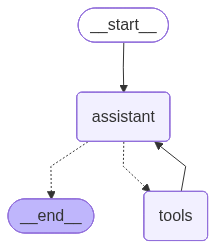

In [33]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

# I Added checkpointer to the graph to retain memory [IMP]

In [34]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()
react_graph_memory = builder.compile(checkpointer=memory)

## I created a thread ID

### run1

In [42]:
# Specify a thread
config = {"configurable": {"thread_id": "2"}}

# Specify an input
messages = [HumanMessage(content="Take the factorial of 3, multiply this result with 2 , add 6 to this result , then divide this result by 2, add 4 to the output")]

# Run
messages = react_graph_memory.invoke({"messages": messages},config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Take the factorial of 3, multiply the result with 2 , add 5 to the result divide the result by 2, add 4 to the output
================================== Ai Message ==================================
Tool Calls:
  factorial (call_jXlrYhhX5pvzXF4IYcXYrzEm)
 Call ID: call_jXlrYhhX5pvzXF4IYcXYrzEm
  Args:
    n: 3
================================= Tool Message =================================
Name: factorial

6
================================== Ai Message ==================================
Tool Calls:
  multiply (call_KHcuQqDO3GDA7aA0v2sENmQA)
 Call ID: call_KHcuQqDO3GDA7aA0v2sENmQA
  Args:
    a: 6
    b: 2
  add (call_Qvy9c7GZNsHvz8opRIIFn481)
 Call ID: call_Qvy9c7GZNsHvz8opRIIFn481
  Args:
    a: 6
    b: 5
================================= Tool Message =================================
Name: multiply

12
================================= Tool Message =================================
Name: add

11
=====

### run2

In [43]:
messages = [HumanMessage(content="Multiply that by 4.")]
messages = react_graph_memory.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Take the factorial of 3, multiply the result with 2 , add 5 to the result divide the result by 2, add 4 to the output
================================== Ai Message ==================================
Tool Calls:
  factorial (call_jXlrYhhX5pvzXF4IYcXYrzEm)
 Call ID: call_jXlrYhhX5pvzXF4IYcXYrzEm
  Args:
    n: 3
================================= Tool Message =================================
Name: factorial

6
================================== Ai Message ==================================
Tool Calls:
  multiply (call_KHcuQqDO3GDA7aA0v2sENmQA)
 Call ID: call_KHcuQqDO3GDA7aA0v2sENmQA
  Args:
    a: 6
    b: 2
  add (call_Qvy9c7GZNsHvz8opRIIFn481)
 Call ID: call_Qvy9c7GZNsHvz8opRIIFn481
  Args:
    a: 6
    b: 5
================================= Tool Message =================================
Name: multiply

12
================================= Tool Message =================================
Name: add

11
=====

### run3

In [44]:
messages = [HumanMessage(content="subtract 6 from that.")]
messages = react_graph_memory.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Take the factorial of 3, multiply the result with 2 , add 5 to the result divide the result by 2, add 4 to the output
================================== Ai Message ==================================
Tool Calls:
  factorial (call_jXlrYhhX5pvzXF4IYcXYrzEm)
 Call ID: call_jXlrYhhX5pvzXF4IYcXYrzEm
  Args:
    n: 3
================================= Tool Message =================================
Name: factorial

6
================================== Ai Message ==================================
Tool Calls:
  multiply (call_KHcuQqDO3GDA7aA0v2sENmQA)
 Call ID: call_KHcuQqDO3GDA7aA0v2sENmQA
  Args:
    a: 6
    b: 2
  add (call_Qvy9c7GZNsHvz8opRIIFn481)
 Call ID: call_Qvy9c7GZNsHvz8opRIIFn481
  Args:
    a: 6
    b: 5
================================= Tool Message =================================
Name: multiply

12
================================= Tool Message =================================
Name: add

11
=====

### run4

In [45]:
messages = [HumanMessage(content="divide that by 2 .")]
messages = react_graph_memory.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Take the factorial of 3, multiply the result with 2 , add 5 to the result divide the result by 2, add 4 to the output
================================== Ai Message ==================================
Tool Calls:
  factorial (call_jXlrYhhX5pvzXF4IYcXYrzEm)
 Call ID: call_jXlrYhhX5pvzXF4IYcXYrzEm
  Args:
    n: 3
================================= Tool Message =================================
Name: factorial

6
================================== Ai Message ==================================
Tool Calls:
  multiply (call_KHcuQqDO3GDA7aA0v2sENmQA)
 Call ID: call_KHcuQqDO3GDA7aA0v2sENmQA
  Args:
    a: 6
    b: 2
  add (call_Qvy9c7GZNsHvz8opRIIFn481)
 Call ID: call_Qvy9c7GZNsHvz8opRIIFn481
  Args:
    a: 6
    b: 5
================================= Tool Message =================================
Name: multiply

12
================================= Tool Message =================================
Name: add

11
=====

## I created another thread ID

### run1

In [46]:
# Specify a thread
config = {"configurable": {"thread_id": "5"}}

# Specify an input
messages = [HumanMessage(content="Take the factorial of 3")]

# Run
messages = react_graph_memory.invoke({"messages": messages},config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Take the factorial of 3
================================== Ai Message ==================================
Tool Calls:
  factorial (call_9Vew8hxqBtdmV7Cvh7tCDCVY)
 Call ID: call_9Vew8hxqBtdmV7Cvh7tCDCVY
  Args:
    n: 3
================================= Tool Message =================================
Name: factorial

6
================================== Ai Message ==================================

The factorial of 3 is 6.


### run2

In [47]:
messages = [HumanMessage(content="subtract 4 from that.")]
messages = react_graph_memory.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Take the factorial of 3
================================== Ai Message ==================================
Tool Calls:
  factorial (call_9Vew8hxqBtdmV7Cvh7tCDCVY)
 Call ID: call_9Vew8hxqBtdmV7Cvh7tCDCVY
  Args:
    n: 3
================================= Tool Message =================================
Name: factorial

6
================================== Ai Message ==================================

The factorial of 3 is 6.
================================ Human Message =================================

subtract 4 from that.
================================== Ai Message ==================================
Tool Calls:
  subtract (call_v0zGfgOPC2mJpRkMTsry9KEM)
 Call ID: call_v0zGfgOPC2mJpRkMTsry9KEM
  Args:
    a: 6
    b: 4
================================= Tool Message =================================
Name: subtract

2
================================== Ai Message ==================================

Subtra

### run3

In [48]:
messages = [HumanMessage(content="multiply this with 5.")]
messages = react_graph_memory.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Take the factorial of 3
================================== Ai Message ==================================
Tool Calls:
  factorial (call_9Vew8hxqBtdmV7Cvh7tCDCVY)
 Call ID: call_9Vew8hxqBtdmV7Cvh7tCDCVY
  Args:
    n: 3
================================= Tool Message =================================
Name: factorial

6
================================== Ai Message ==================================

The factorial of 3 is 6.
================================ Human Message =================================

subtract 4 from that.
================================== Ai Message ==================================
Tool Calls:
  subtract (call_v0zGfgOPC2mJpRkMTsry9KEM)
 Call ID: call_v0zGfgOPC2mJpRkMTsry9KEM
  Args:
    a: 6
    b: 4
================================= Tool Message =================================
Name: subtract

2
================================== Ai Message ==================================

Subtra

### run4

In [49]:
messages = [HumanMessage(content="subtract 4, then factorial this output, then subtract 200 from this output and divide the final output by 10.")]
messages = react_graph_memory.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Take the factorial of 3
================================== Ai Message ==================================
Tool Calls:
  factorial (call_9Vew8hxqBtdmV7Cvh7tCDCVY)
 Call ID: call_9Vew8hxqBtdmV7Cvh7tCDCVY
  Args:
    n: 3
================================= Tool Message =================================
Name: factorial

6
================================== Ai Message ==================================

The factorial of 3 is 6.
================================ Human Message =================================

subtract 4 from that.
================================== Ai Message ==================================
Tool Calls:
  subtract (call_v0zGfgOPC2mJpRkMTsry9KEM)
 Call ID: call_v0zGfgOPC2mJpRkMTsry9KEM
  Args:
    a: 6
    b: 4
================================= Tool Message =================================
Name: subtract

2
================================== Ai Message ==================================

Subtra

## Observed and analysed the graph with memory in the LangGraph studio

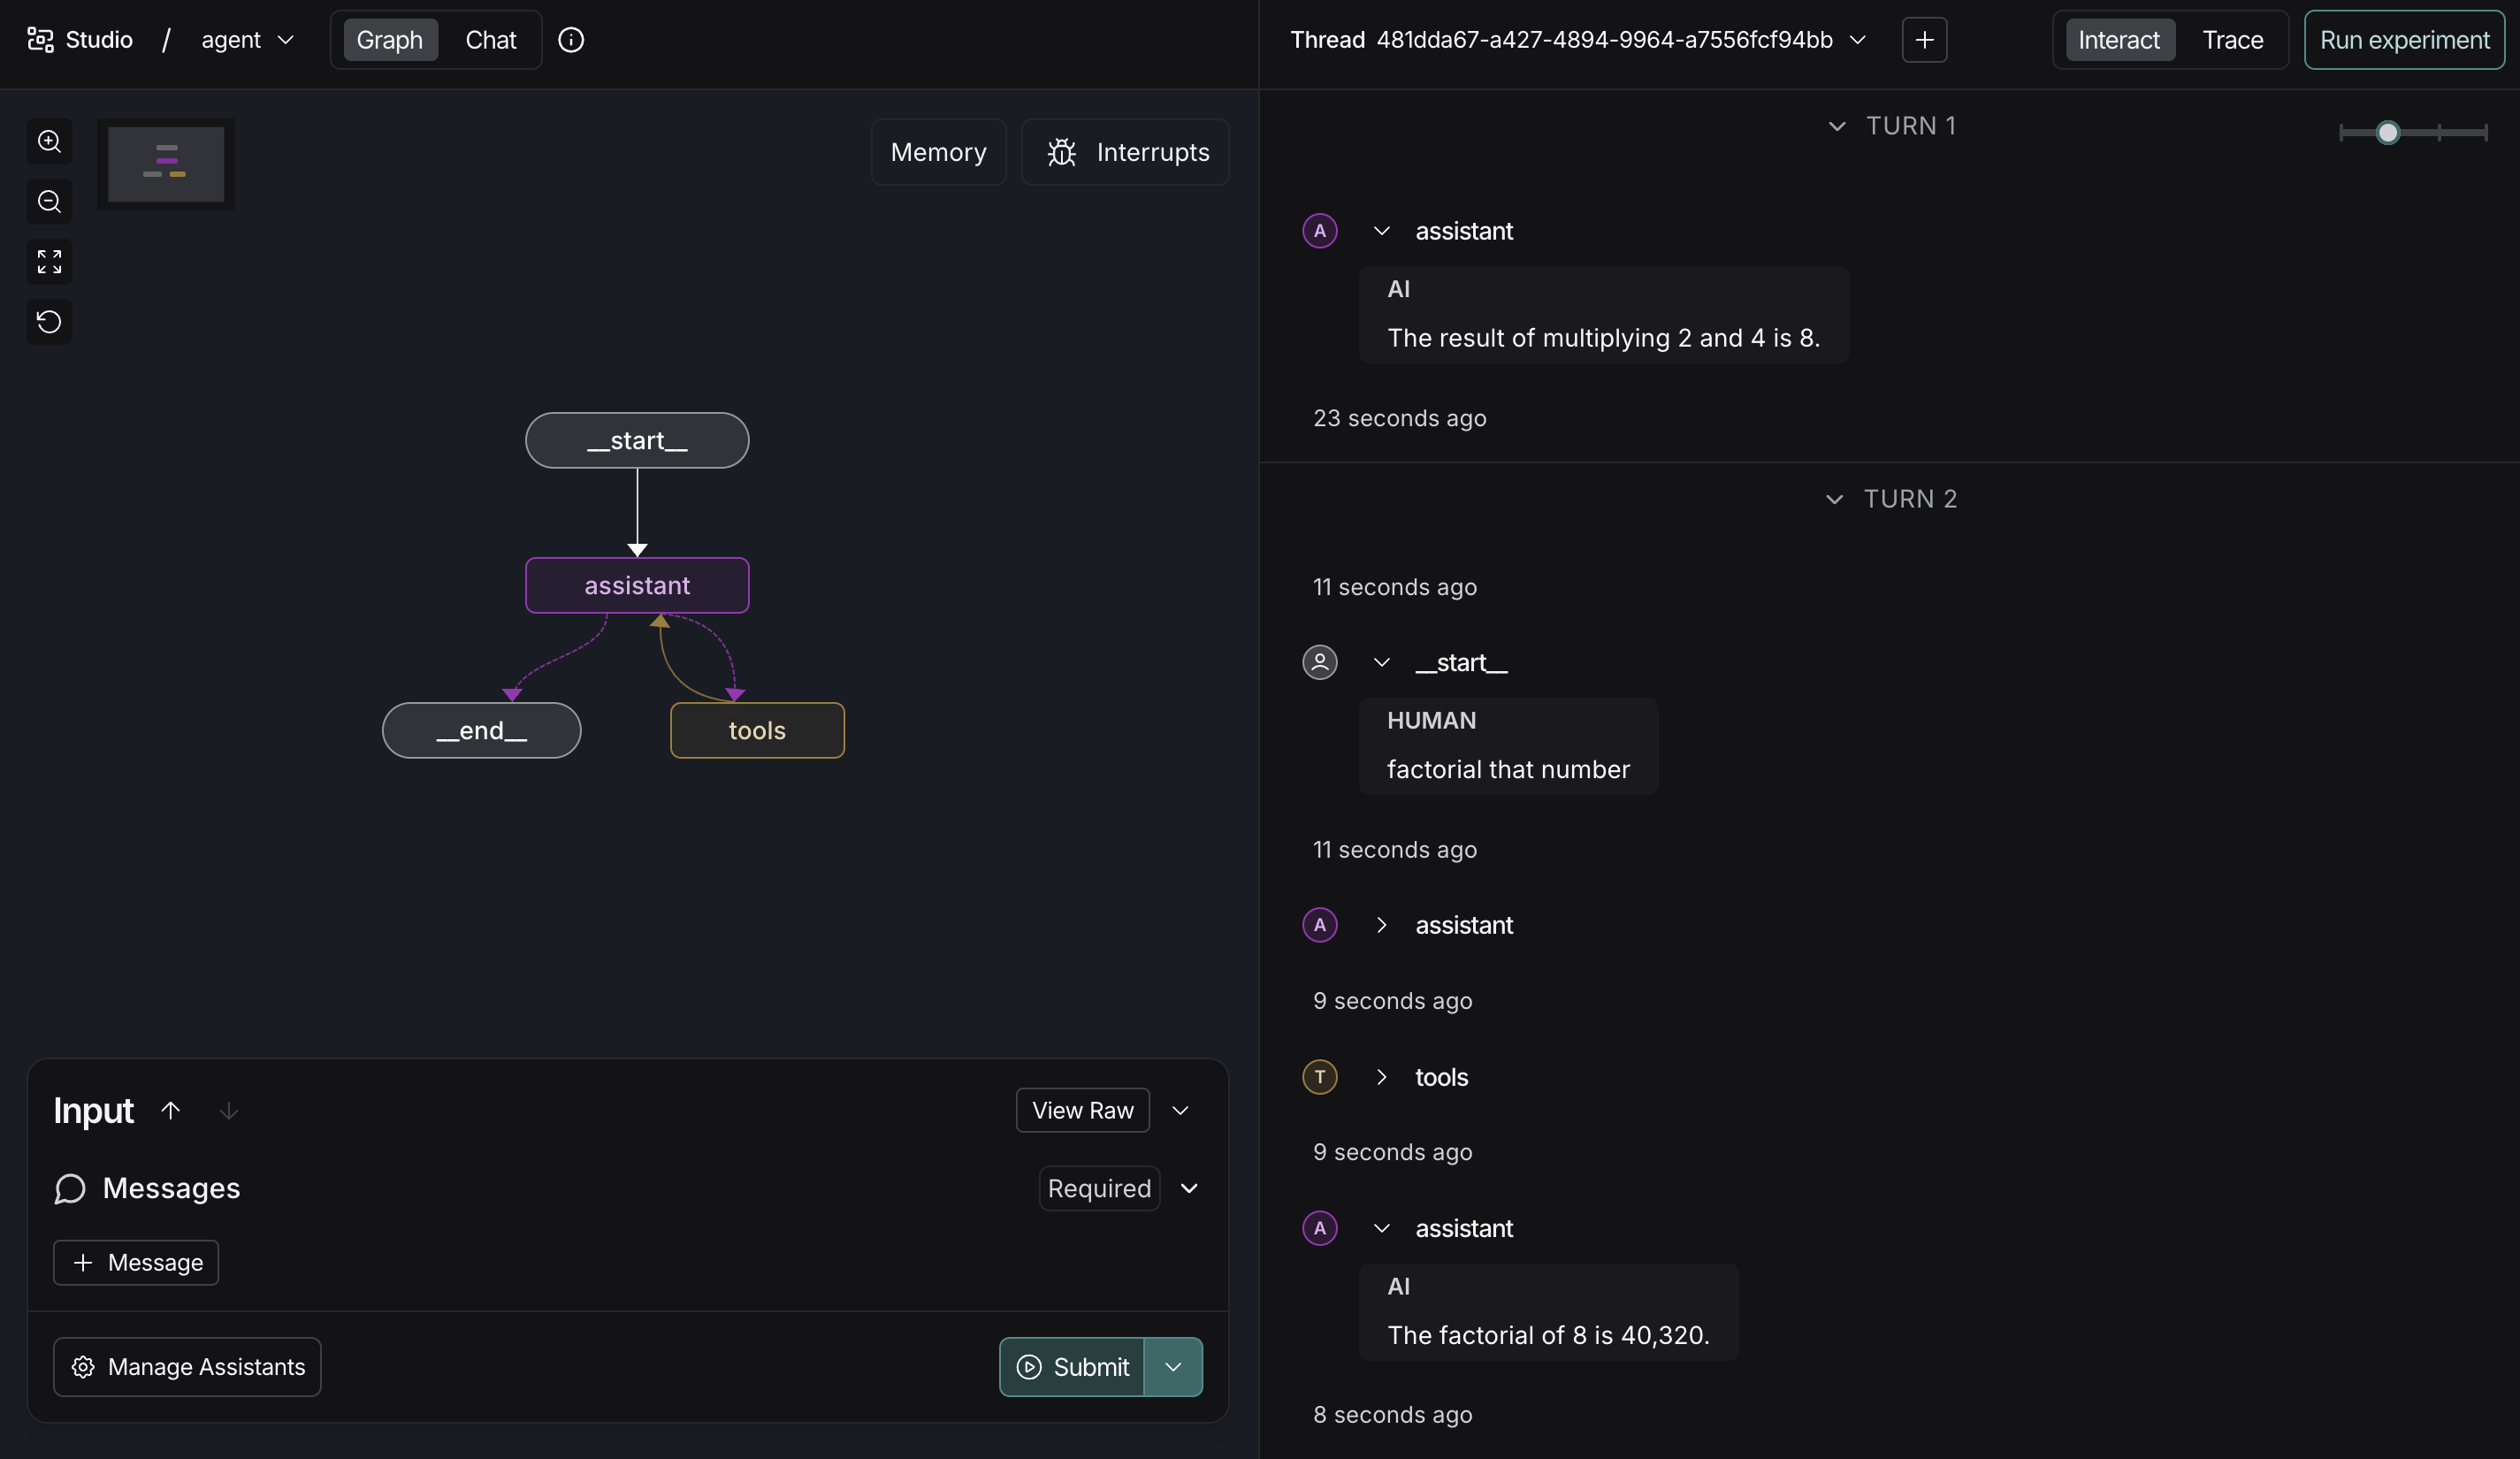

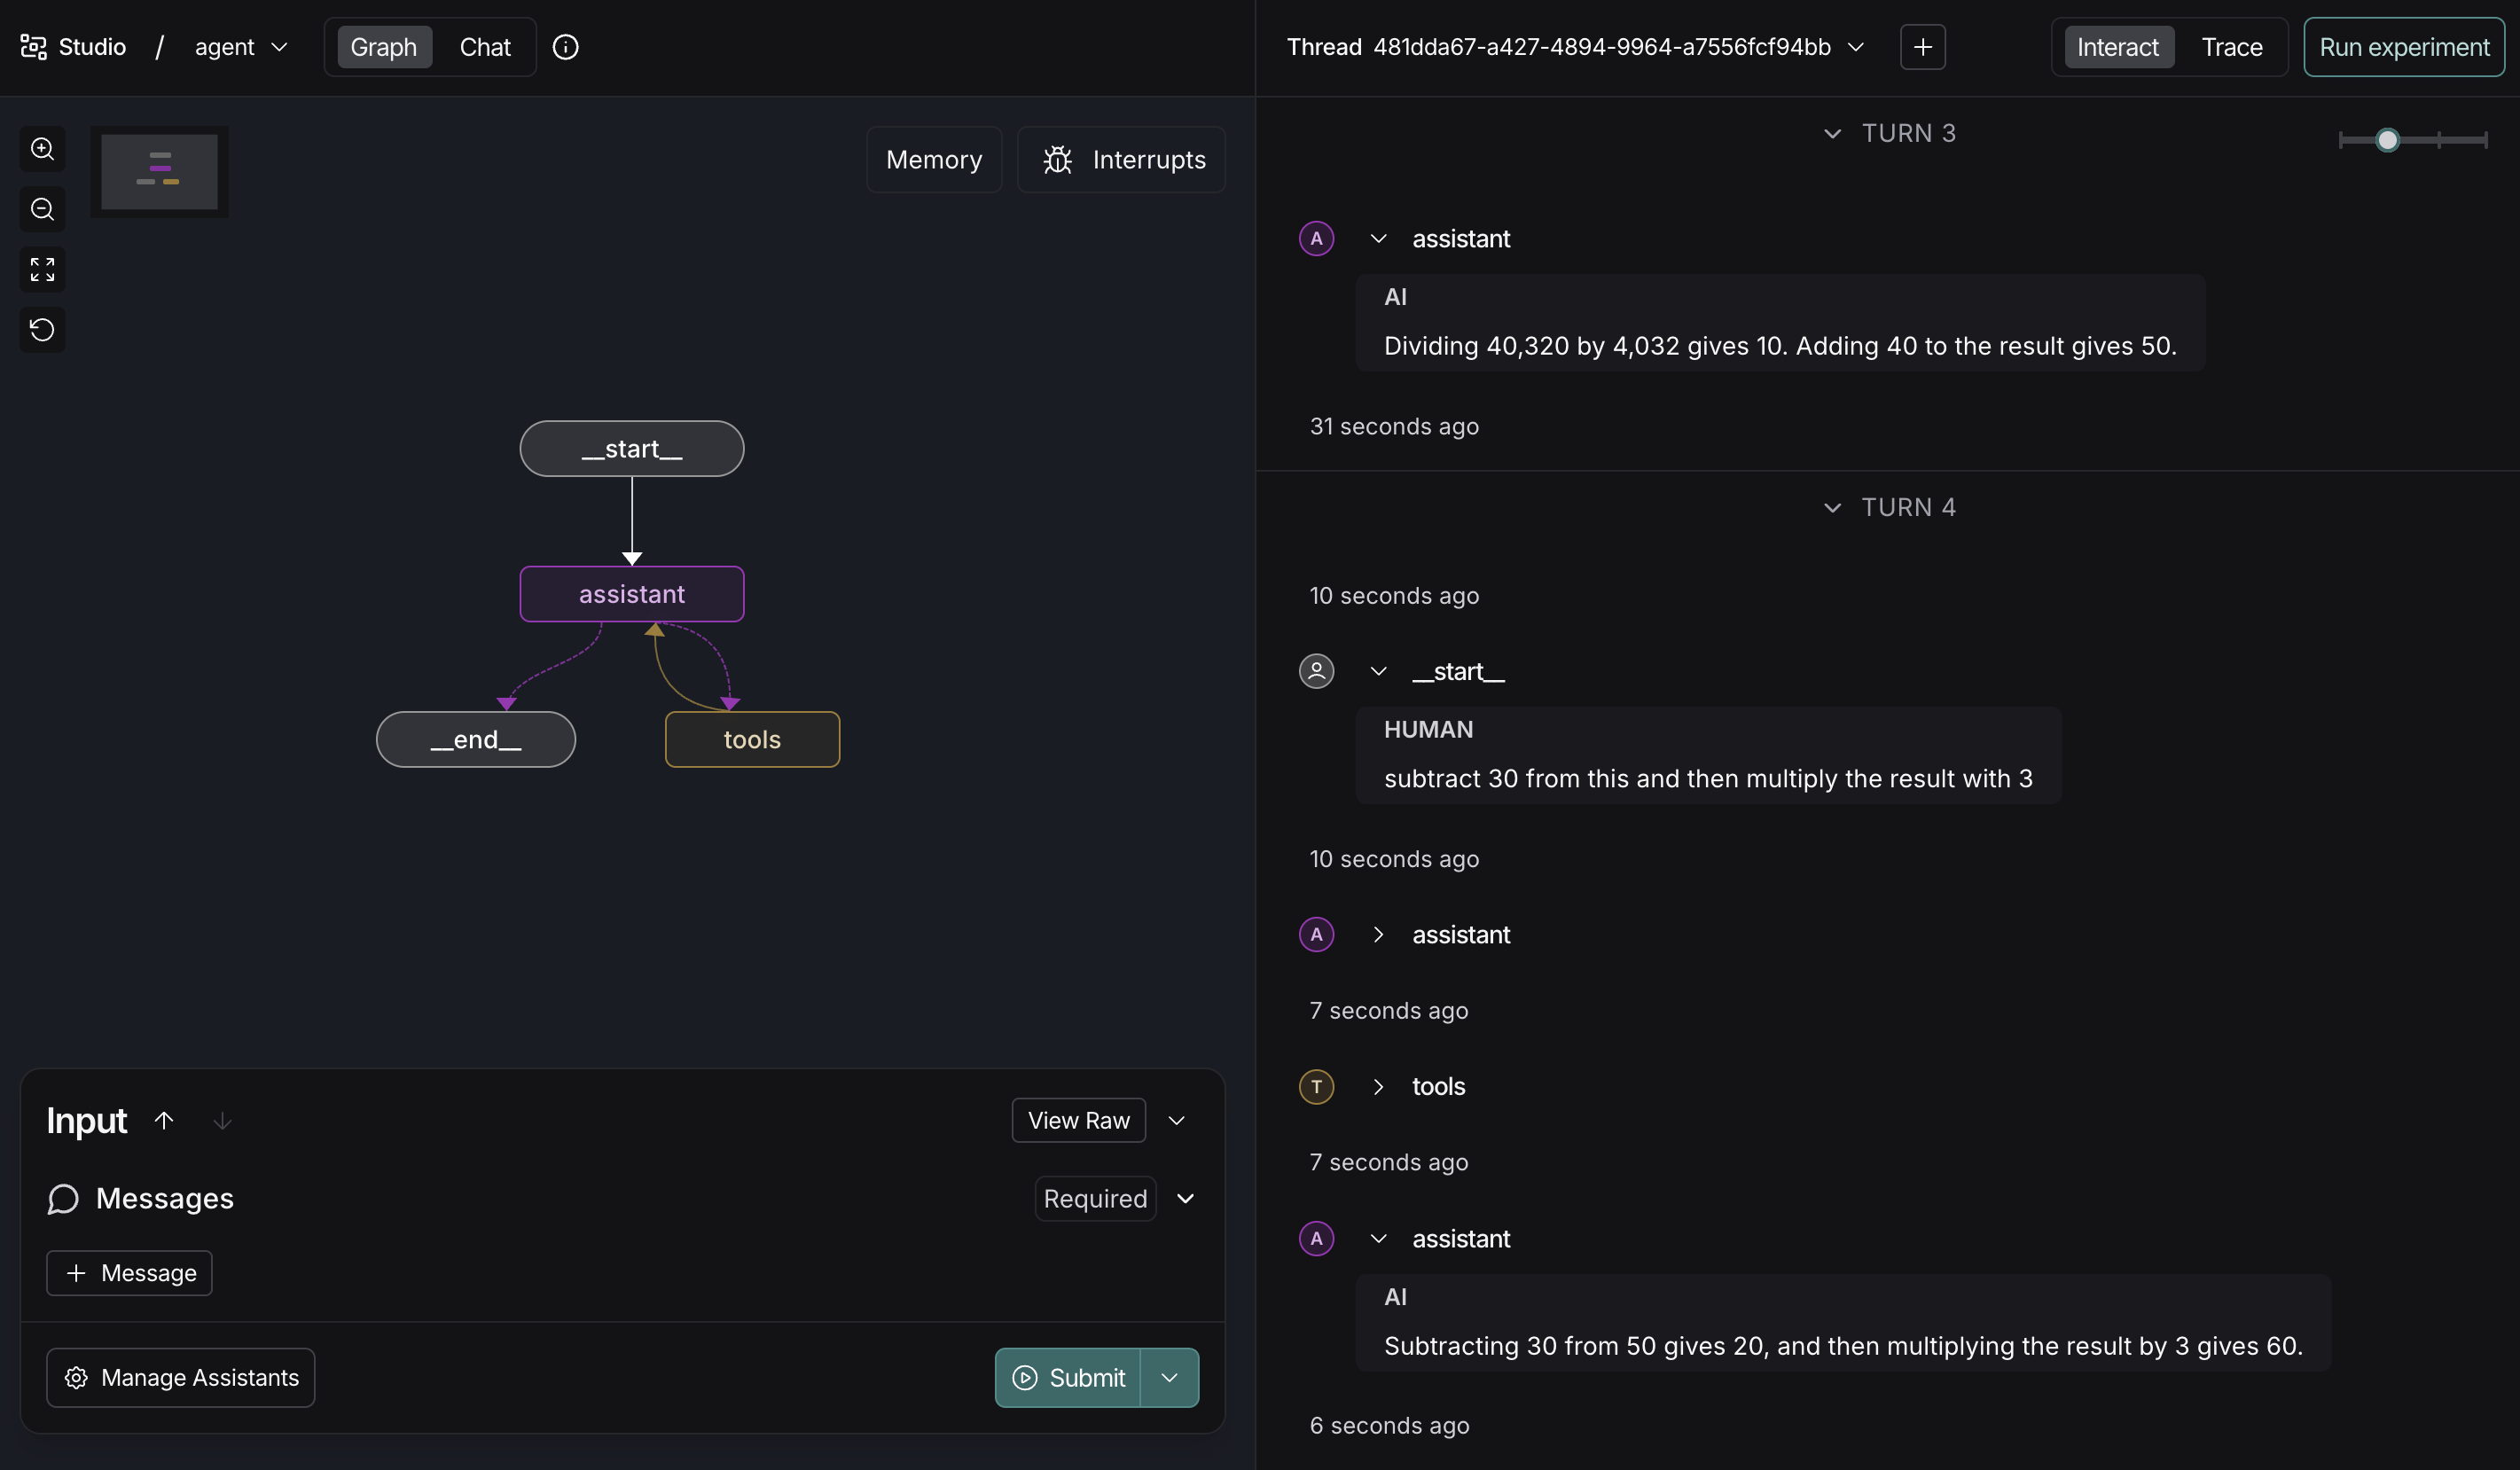

## It gracefully handled the successive runs and gave the correct answers